# Perlin noise-based classifier


## Description
The proposed Perlin noise-based classifier is a supervised binary classifier that is intended to use genetic algorithms (or other suitable means for optimization) to evolve a set of parameters in order to match the landscape generated by an n-dimensional Perlin noise with that of a given problem, so that values below a threshold represent one class and values above that threshold represent the other class.

Given a binary classification problem for which the inputs represent a vector with n numerical values, the parameters that constitute the solution are the following:
 - seed: number - random number generator for noise, can be used for a strong mutation of the solution
 - octaves: number - positive integer representing the number of Perlin Noise layers (or turbulence), can be used for finer details in map
 - threshold: number in interval [0,1] - threshold for classification
 - scale1: number - scaling factor across first noise dimension
 - offset1: number - offset term across first noise dimension
 - ...
 - scaleN: number - scaling factor across n-th noise dimension
 - offsetN: number - offset term across n-th noise dimension
 - zOffset: number - offset term across (n+1)-th noise dimension, an additional dimension used to sample a slice with features continuous in this dimension, used for weak mutation of the solution

 Other parameters can be added in order to manipulate the noise, such as rotation or turbulence.

Inputs will then be classified by calculating the value of the Perlin noise in the point represented by the individual's input vector, which should return a value loosely constrained in [0, 1], depending on Perlin noise implementation. This value will be compared with the threshold in order to determine the class.

## Implementation

In this notebook, a genetic algorithm will be implemented in order to perform the search in the parameter space for a set of parameters for which the generated noise can model the problem landscape

Required libraries

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt;
import copy

import random
from random import randint
from random import seed 
from math import floor
from math import sqrt
from perlin_noise import PerlinNoise;
from tkinter import filedialog

File load function

In [3]:
# load data
def loadData(fileName):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1
    
    cleanData(data)
    return data, dataNames

def cleanData(data):
    for row in data:
        for i in range(0, len(row)):
            if row[i] == None or row[i] == "":
                data.remove(row) 

def getDataColumn(data, dataNames, columnName):
    i = dataNames.index(columnName)
    dataColumn = [row[i] for row in data]
    return dataColumn

Select input file

In [4]:
filePath = filedialog.askopenfilename()

Load data from file

In [5]:
data, dataNames = loadData(filePath)
ids = getDataColumn(data, dataNames, 'Id')
sepalLengths = getDataColumn(data, dataNames, 'SepalLengthCm')
sepalWidths = getDataColumn(data, dataNames, 'SepalWidthCm')
petalLengths = getDataColumn(data, dataNames, 'PetalLengthCm')
petalWidths = getDataColumn(data, dataNames, 'PetalWidthCm')
results = getDataColumn(data, dataNames, 'Species')

inputs = [[float(petalLengths[i]), float(petalWidths[i])] for i in range(0, len(results))]

Split data into train and validation sets (according to work it is compared against)

In [6]:
np.random.seed(5)
indexes = [i for i in range(len(inputs))]
trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
validationSample = [i for i in indexes  if not i in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainResults = [results[i] for i in trainSample]

validationInputs = [inputs[i] for i in validationSample]
validationResults = [results[i] for i in validationSample]

Normalize data according to training data

In [7]:
class ZNormalizer():
    def __init__(self):
        self._average = []
        self._stddev = []

    def fit(self, data):
        for dim in range(0, len(data[0])):
            dataSum = 0
            for entry in data:
                dataSum += entry[dim]
            self._average.append(dataSum / len(data))
            variance = 0
            for entry in data:
                variance += abs(entry[dim] - self._average[dim]) ** 2
            variance /= len(data) - 1
            self._stddev.append(sqrt(variance))

    def transform(self, data):
        for dim in range(0, len(data[0])):
            for entry in data:
                entry[dim] = (entry[dim] - self._average[dim]) / self._stddev[dim]
        return data

scaler = ZNormalizer()
scaler.fit(trainInputs)
trainInputs = scaler.transform(trainInputs)
validationInputs = scaler.transform(validationInputs)

Define confusion matrix function

In [8]:
def getConfusionMatrix(predictedResults, realResults):
    values = dict()
    for i in range(len(predictedResults)):
        expected = realResults[i]
        predicted = predictedResults[i]
        if not expected in values:
            values[expected] = True;
        if not predicted in values:
            values[predicted] = True;
    
    values = values.keys()

    confusionMatrix = dict()
    for value in values:
        row = dict()
        for value2 in values:
            row[value2] = 0
        confusionMatrix[value] = row

    for i in range(len(predictedResults)):
        expected = realResults[i]
        predicted = predictedResults[i]
        confusionMatrix[predicted][expected] += 1

    return confusionMatrix

Define function for getting classification metrics (accuracy, precision and recall)

In [9]:
def getMetrics(predictedResults, realResults):
    guessCount = len(predictedResults)
    confusionMatrix = getConfusionMatrix(predictedResults, realResults)
    classes = confusionMatrix.keys()

    accuracy = 0
    for label in classes:
        accuracy += confusionMatrix[label][label]
    accuracy = accuracy / guessCount

    precisions = []
    for label in classes:
        rowSum = 0
        for label2 in classes:
            rowSum += confusionMatrix[label][label2]
        precision = 1
        if (rowSum != 0):
            precision = confusionMatrix[label][label] / rowSum
        precisions.append(precision)

    recalls = []
    for label in classes:
        columnSum = 0
        for label2 in classes:
            columnSum += confusionMatrix[label2][label]
        recall = 1
        if (columnSum != 0):
            recall = confusionMatrix[label][label] / columnSum
        recalls.append(recall)

    return accuracy, precisions, recalls

Define accuracy function for use in fitness function

In [10]:
def computeAccuracy(predictedResults, realResults):
    accuracy, _, _ = getMetrics(predictedResults, realResults)
    return accuracy

# testing fitness function
testOutputs = [0, 1, 1, 0]
assert(computeAccuracy(testOutputs, testOutputs) - 1 < 0.01)
testInputs = [0, 0, 0, 0]
assert(computeAccuracy(testInputs, testOutputs) < 0.99)

## Genetic algorithm implementation
A problem in which it is desired to classify an input with N features is being considered for the following statements.

For the representation of the chromosome in the program, the following format will be chosen.

[seed, octaves, threshold, scale1, offset1, scale2, offset2, ..., scaleN, offsetN, zOffset]

The fitness function is associated with the ``computeFitness`` functions defined further below. It is desirable of the genetic algorithm to maximize this function and, thus, to maximize the accuracy

In [11]:
N = len(inputs[0])

The following methods are considered for the genetic operators:
 - Initial population generation:
    - seed - random integer value between 0 and 100,000,000
    - octave - random integer value between 1 and 256
    - threshold - random float number between 0.1 and 0.9
    - scales - random float values between -10 and 10
    - offsets - random float values between -10 and 10
    - zOffset - random float value between -10 and 10
 - Selection: two individuals randomly chosen from the population will be compared, choosing the most fit
 - Soft mutation: one of the following values will be altered as explained
   - octave - will be offset by a random integer value between -1 and 1, limited to initial interval
   - threshold - will be offset by a random float value between -0.1 and 0.1, limited to initial interval
   - scales - will be offset by a random float value between -0.1 and 0.1
   - offsets - will be offset by a random float value between -0.5 and 0.5
   - zOffset - will be offset by a random float value between -0.1 and 0.1
 - Hard mutation: seed will become a random integer value between 0 and 1,000,000
 - Crossover: will be done between 2 individuals
   - seed - the seed of one of the parents will be taken
   - octave - a random integer value between the octave values of parents
   - threshold - a random float value between the threshold values of parents
   - scales - random float values between the scale values of parents for respective i in N
   - offsets - random float values between the offset values of parents for respective i in N
   - zOffset - random float value between the zOffset values of parents

In [12]:
def rand(a, b):
    mn = min(a, b)
    mx = max(a, b)
    return mn + (mx-mn) * random.random()

#wrap functions to tolerate invalid intervals
original_randint = randint
def randint(a, b):
    mn = min(a, b)
    mx = max(a, b)
    return original_randint(mn, mx)

def clamp(v, a, b):
    if v < a:
        return a
    if v > b:
        return b
    return v

class Chromosome:
    def __init__(self, GAParams = None, representation = None):
        #avoid initing repres if already given
        if representation:
            self.__GAParams = GAParams
            self.__representation = representation
            self.__fitness = 0.0
            return;

        #vars
        self.__GAParams = GAParams
        #mx = GAParams['max']
        #source = GAParams['source']
        #destination = GAParams['destination']

        #init
        seed = randint(0, 100000000)
        octaves = randint(1, 10)
        threshold = rand(0.1, 0.9)
        self.__representation = [seed, octaves, threshold]
        for i in range(N):
            scale = rand(-10, 10)
            offset = rand(-10, 10)
            self.__representation.append(scale)
            self.__representation.append(offset)
        zOffset = rand(-10, 10)

        self.__fitness = 0.0
    
    @property
    def representation(self):
        return self.__representation
    
    @property
    def fitness(self):
        return self.__fitness 
    
    @representation.setter
    def representation(self, l = []):
        self.__representation = l 
    
    @fitness.setter 
    def fitness(self, fit = 0.0):
        self.__fitness = fit 
    
    def crossover(self, c):
        newRepresentation = []
        #seed
        newRepresentation.append(self.__representation[0] if random.random() < 0.5 else c.__representation[0])
        #octave
        newRepresentation.append(randint(self.__representation[1], c.__representation[1]))
        #threshold
        newRepresentation.append(rand(self.__representation[2], c.__representation[2]))
        for i in range(N * 2):
            #scales and offsets
            p = 3 + i
            newRepresentation.append(rand(self.__representation[p], c.__representation[p]))
        #zOffset
        newRepresentation.append(rand(self.__representation[-1], c.__representation[-1]))
        offspring = Chromosome(c.__GAParams)
        offspring.representation = newRepresentation
        return offspring
    
    def softMutation(self):
        trait = randint(1, len(self.__representation) - 1)
        if trait == 1:
            #octave
            self.__representation[1] = clamp(self.__representation[1] + randint(-1, 1), 1, 10)
        elif trait == 2:
            #threshold
            self.__representation[2] = clamp(self.__representation[2] + rand(-0.1, 0.1), 0.1, 0.9)
        elif trait == len(self.__representation) - 1:
            #zOffset
            self.__representation[-1] += rand(-0.1, 0.1)
        else:
            #scales and offsets
            if trait % 2 == 1: #since first scale is at 3, odd
                #scale
                self.__representation[trait] += rand(-0.1, 0.1)
            else:
                #offset
                self.__representation[trait] += rand(-0.5, 0.5)

    def hardMutation(self):
        self.__representation[0] = randint(0, 100000000)
        
    def __str__(self):
        return '\nChromosome: ' + str(self.__representation) + ' has fitness: ' + str(self.__fitness)
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, c):
        return self.__representation == c.__repres and self.__fitness == c.__fitness

Evolution algorithm implementation

In [13]:
class GA:
    def __init__(self, param = None, problParam = None):
        self.__param = param
        self.__problParam = problParam
        self.__population = []
        
    @property
    def population(self):
        return self.__population
    
    def initialisation(self):
        for _ in range(0, self.__param['popSize']):
            c = Chromosome(self.__problParam)
            self.__population.append(c)
    
    def evaluation(self):
        for c in self.__population:
            c.fitness = self.__problParam['function'](c.representation)
            
    def bestChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness > best.fitness):
                best = c
        return best
        
    def worstChromosome(self):
        worst = self.__population[0]
        for c in self.__population:
            if (c.fitness < worst.fitness):
                worst = c
        return worst

    def selection(self):
        pos1 = randint(0, self.__param['popSize'] - 1)
        pos2 = randint(0, self.__param['popSize'] - 1)
        if (self.__population[pos1].fitness > self.__population[pos2].fitness):
            return pos1
        else:
            return pos2 
    
    def oneGeneration(self):
        newPop = []
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.softMutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationElitism(self):
        newPop = [self.bestChromosome()]
        for _ in range(self.__param['popSize'] - 1):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.softMutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()
        
    def oneGenerationSteadyState(self):
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.softMutation()
            off.fitness = self.__problParam['function'](off.representation)
            worst = self.worstChromosome()
            if (off.fitness > worst.fitness):
                worst.representation = off.representation
                worst.fitness = off.fitness

Evolution algorithm application for iris classification, one versus rest: common part

In [14]:
random.seed(None)

def computeFitnessIris(iris_class):
    """
    returns an evaluation function for a given iris class
    iris_class: string: one of "Iris-setosa" | "Iris-versicolor" | "Iris-virginica"
    """
    classResults = [result == iris_class for result in trainResults]
    def computeFitness(solution):
        seed = solution[0]
        octaves = solution[1]
        threshold = solution[2]
        zOffset = solution[-1]

        noise = PerlinNoise(seed=seed, octaves=octaves)

        computedResults = []
        for input in trainInputs:
            processedInput = [] #copy.copy(input)
            for i in range(len(input)):
                scale = solution[2*i + 3]
                offset = solution[2*i + 4]
                value = input[i]
                processedInput.append(value * scale + offset)
            processedInput.append(zOffset)
            result = noise(processedInput) + 0.5 > threshold
            computedResults.append(result)

        return computeAccuracy(computedResults, classResults)

    return computeFitness

# initialize the GA parameters
# note: will actually use 50 more generations for versicolor
gaParam = {'popSize' : 100, 'noGen' : 100, 'pc' : 0.8, 'pm' : 0.1}

Iris setosa classification

Best solution in generation 99 is: x = [78409036, 1, 0.6874920128974498, -0.0471242687943538, 0.352692672075289, 1.2181601244318592, 3.8830012571434676, 3.1572653349646287] f(x) = 1.0
Best solution is: x = [28140527, 2, 0.7822746656087203, -0.2884691519444422, -1.3948085527063896, -0.17791440622909271, 2.317161354366226, 0.18258895031437183] f(x) = 1.0


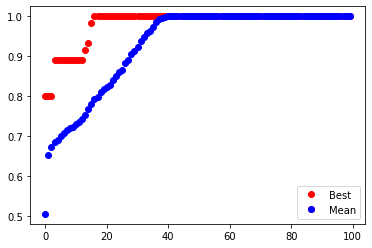

In [15]:
# problem parameters
setosaParam = {'function': computeFitnessIris("Iris-setosa")}

# store the best/average solution of each iteration (for a final plot used to analyze the GA's convergence)
allBestFitnesses = []
allAvgFitnesses = []
generations = []

ga = GA(gaParam, setosaParam)
ga.initialisation()
ga.evaluation()
    
overallBestChromo = ga.bestChromosome()
overallBestSolY = overallBestChromo.fitness
for g in range(gaParam['noGen']):
    #plotting preparation
    allPotentialSolutionsX = [c.representation for c in ga.population]
    allPotentialSolutionsY = [c.fitness for c in ga.population]
    bestChromo = ga.bestChromosome()
    bestSolX = bestChromo.representation
    bestSolY = bestChromo.fitness
    allBestFitnesses.append(bestSolY)
    allAvgFitnesses.append(sum(allPotentialSolutionsY) / len(allPotentialSolutionsY))
    generations.append(g)

    #evolution algorithm
    ga.oneGenerationSteadyState()
    #ga.oneGeneration()
    #ga.oneGenerationElitism()
    
    if bestSolY > overallBestSolY:
        overallBestChromo = bestChromo
        overallBestSolY = bestSolY

print('Best solution in generation ' + str(g) + ' is: x = ' + str(bestChromo.representation) + ' f(x) = ' + str(bestChromo.fitness))
print('Best solution is: x = ' + str(overallBestChromo.representation) + ' f(x) = ' + str(overallBestChromo.fitness))
    
plt.ioff()
best, = plt.plot(generations, allBestFitnesses, 'ro', label = 'best')
mean, = plt.plot(generations, allAvgFitnesses, 'bo', label = 'mean')
plt.legend([best, (best, mean)], ['Best', 'Mean'])
plt.show()

irisSetosaBestChromosome = overallBestChromo

Iris versicolor classification

Best solution in generation 99 is: x = [33264813, 2, 0.7649908336776647, 0.2289418608615815, -0.7745877292990619, 0.26082972202633403, -2.621687591285666, -3.032832780301047] f(x) = 0.975
Best solution is: x = [33264813, 2, 0.7705195272648544, 0.21244761052476854, -0.7783730488913154, 0.23586510618175288, -2.620648142537652, -2.9657485712878677] f(x) = 0.975


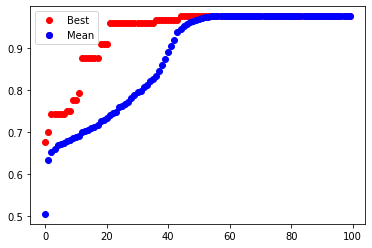

In [24]:
# problem parameters
versicolorParam = {'function': computeFitnessIris("Iris-versicolor")}

# store the best/average solution of each iteration (for a final plot used to analyze the GA's convergence)
allBestFitnesses = []
allAvgFitnesses = []
generations = []

ga = GA(gaParam, versicolorParam)
ga.initialisation()
ga.evaluation()
    
overallBestChromo = ga.bestChromosome()
overallBestSolY = overallBestChromo.fitness
for g in range(gaParam['noGen']):
    #plotting preparation
    allPotentialSolutionsX = [c.representation for c in ga.population]
    allPotentialSolutionsY = [c.fitness for c in ga.population]
    bestChromo = ga.bestChromosome()
    bestSolX = bestChromo.representation
    bestSolY = bestChromo.fitness
    allBestFitnesses.append(bestSolY)
    allAvgFitnesses.append(sum(allPotentialSolutionsY) / len(allPotentialSolutionsY))
    generations.append(g)

    #evolution algorithm
    ga.oneGenerationSteadyState()
    #ga.oneGeneration()
    #ga.oneGenerationElitism()
    
    if bestSolY > overallBestSolY:
        overallBestChromo = bestChromo
        overallBestSolY = bestSolY

print('Best solution in generation ' + str(g) + ' is: x = ' + str(bestChromo.representation) + ' f(x) = ' + str(bestChromo.fitness))
print('Best solution is: x = ' + str(overallBestChromo.representation) + ' f(x) = ' + str(overallBestChromo.fitness))
    
plt.ioff()
best, = plt.plot(generations, allBestFitnesses, 'ro', label = 'best')
mean, = plt.plot(generations, allAvgFitnesses, 'bo', label = 'mean')
plt.legend([best, (best, mean)], ['Best', 'Mean'])
plt.show()

irisVersicolorBestChromosome = overallBestChromo

Iris virginica classification

Best solution in generation 99 is: x = [14777920, 2, 0.6400029391247986, 0.36977206703546933, 2.143420202483658, 0.09485476091947989, -0.006489713090604253, 1.3700259896896776] f(x) = 0.975
Best solution is: x = [14777920, 2, 0.6400029391247986, 0.36977206703546933, 2.143420202483658, 0.09485476091947989, -0.006489713090604253, 1.3700259896896776] f(x) = 0.975


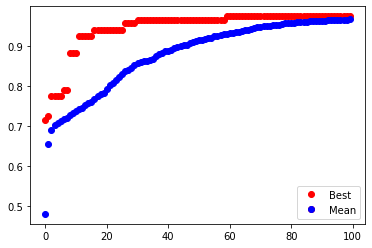

In [25]:
# problem parameters
virginicaParam = {'function': computeFitnessIris("Iris-virginica")}

# store the best/average solution of each iteration (for a final plot used to analyze the GA's convergence)
allBestFitnesses = []
allAvgFitnesses = []
generations = []

ga = GA(gaParam, virginicaParam)
ga.initialisation()
ga.evaluation()
    
overallBestChromo = ga.bestChromosome()
overallBestSolY = overallBestChromo.fitness
for g in range(gaParam['noGen']):
    #plotting preparation
    allPotentialSolutionsX = [c.representation for c in ga.population]
    allPotentialSolutionsY = [c.fitness for c in ga.population]
    bestChromo = ga.bestChromosome()
    bestSolX = bestChromo.representation
    bestSolY = bestChromo.fitness
    allBestFitnesses.append(bestSolY)
    allAvgFitnesses.append(sum(allPotentialSolutionsY) / len(allPotentialSolutionsY))
    generations.append(g)

    #evolution algorithm
    ga.oneGenerationSteadyState()
    #ga.oneGeneration()
    #ga.oneGenerationElitism()
    
    if bestSolY > overallBestSolY:
        overallBestChromo = bestChromo
        overallBestSolY = bestSolY

print('Best solution in generation ' + str(g) + ' is: x = ' + str(bestChromo.representation) + ' f(x) = ' + str(bestChromo.fitness))
print('Best solution is: x = ' + str(overallBestChromo.representation) + ' f(x) = ' + str(overallBestChromo.fitness))
    
plt.ioff()
best, = plt.plot(generations, allBestFitnesses, 'ro', label = 'best')
mean, = plt.plot(generations, allAvgFitnesses, 'bo', label = 'mean')
plt.legend([best, (best, mean)], ['Best', 'Mean'])
plt.show()

irisVirginicaBestChromosome = overallBestChromo

Visualization of iris setosa classifier (2D)

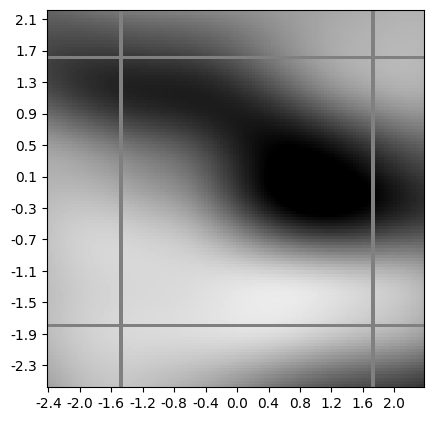

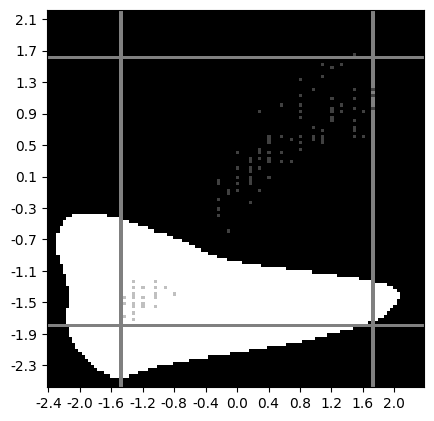

In [26]:
representation = irisSetosaBestChromosome.representation
seed = representation[0]
octaves = representation[1]
threshold = representation[2]
scaleX = representation[3]
offsetX = representation[4]
scaleY = representation[5]
offsetY = representation[6]
zOffset = representation[-1]

imageScale = 4
imageOffset = 2

setosaNoise = PerlinNoise(seed=seed, octaves=octaves)
imageWidth, imageHeight = 100, 100
border = 10

minX = floor((min(inputs, key=lambda input: input[0])[0] + imageOffset) * imageWidth / imageScale)
minY = floor((min(inputs, key=lambda input: input[1])[1] + imageOffset) * imageHeight / imageScale)
maxX = floor((max(inputs, key=lambda input: input[0])[0] + imageOffset) * imageWidth / imageScale)
maxY = floor((max(inputs, key=lambda input: input[1])[1] + imageOffset) * imageHeight / imageScale)

pic = []
for i in range(imageHeight + border, -border, -1):
    row = []
    for j in range(-border, imageWidth + border, 1):
        input = [(i / imageHeight - imageOffset / imageScale) * imageScale, (j / imageWidth - imageOffset / imageScale) * imageScale]
        processedInput = [] #copy.copy(input)
        for k in range(len(input)):
            scale = representation[2*k + 3]
            offset = representation[2*k + 4]
            value = input[k]
            processedInput.append(value * scale + offset)
        processedInput.append(zOffset)

        value = setosaNoise(processedInput) + 0.5
        if i == minX-1 or i == maxX or j == minY-1 or j == maxY:
            value = 0.5
        row.append(value)
    pic.append(row)

#pic = [[noise([i/imageWidth * scaleX + offsetX, j/imageHeight * scaleY + offsetY]) for j in range(imageWidth, 0, -1)] for i in range(imageHeight)]

plt.figure(figsize=(5,5), dpi=100)
xticks = [x for x in range(0, imageWidth + border * 2, 10)]
plt.xticks(xticks, ["%.1f" % (((x - border) / imageWidth - imageOffset / imageScale) * imageScale) for x in xticks])
yticks = [y + border/imageScale for y in range(0, imageHeight + border * 2, 10)]
plt.yticks(yticks, reversed(["%.1f" % (((y - border) / imageHeight - imageOffset / imageScale) * imageScale) for y in yticks]))
plt.imshow(pic, vmin=0, vmax=1, cmap='gray')
plt.show()

#pic = [[noise([i/imageWidth * scaleX + offsetX, j/imageHeight * scaleY + offsetY]) > threshold for j in range(imageWidth, 0, -1)] for i in range(imageHeight)]
pic2 = []
for i in range(len(pic)):
    row = []
    for j in range(0, len(pic[i]), 1):
        value = pic[i][j] > threshold
        if pic[i][j] == 0.5:
            value = 0.5
        row.append(value)
    pic2.append(row)

for i in range(len(inputs)):
    input = inputs[i]
    processedInput = [] #copy.copy(input)
    for j in range(len(input)):
        scale = representation[2*j + 3]
        offset = representation[2*j + 4]
        value = input[j]
        processedInput.append(value * scale + offset)
    x = floor((imageScale - input[0] - imageOffset) * imageWidth / imageScale + border)
    y = floor((input[1] + imageOffset) * imageHeight / imageScale + border)
    color = 0.75 if results[i] == "Iris-setosa" else 0.25
    if x < len(pic2):
        if y < len(pic2[x]):
            pic2[x][y] = color

plt.figure(figsize=(5,5), dpi=100)
xticks = [x for x in range(0, imageWidth + border * 2, 10)]
plt.xticks(xticks, ["%.1f" % (((x - border) / imageWidth - imageOffset / imageScale) * imageScale) for x in xticks])
yticks = [y + border/imageScale for y in range(0, imageHeight + border * 2, 10)]
plt.yticks(yticks, reversed(["%.1f" % (((y - border) / imageHeight - imageOffset / imageScale) * imageScale) for y in yticks]))
plt.imshow(pic2, vmin=0, vmax=1, cmap='gray')
plt.show()

Visualization of iris versicolor classifier

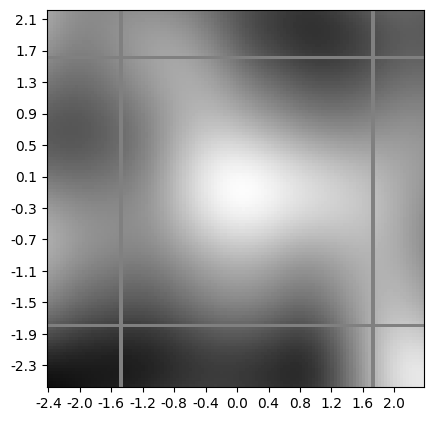

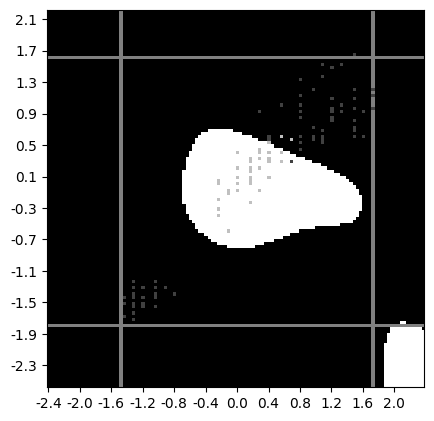

In [27]:
representation = irisVersicolorBestChromosome.representation
seed = representation[0]
octaves = representation[1]
threshold = representation[2]
scaleX = representation[3]
offsetX = representation[4]
scaleY = representation[5]
offsetY = representation[6]
zOffset = representation[-1]

imageScale = 4
imageOffset = 2

versicolorNoise = PerlinNoise(seed=seed, octaves=octaves)
imageWidth, imageHeight = 100, 100
border = 10

minX = floor((min(inputs, key=lambda input: input[0])[0] + imageOffset) * imageWidth / imageScale)
minY = floor((min(inputs, key=lambda input: input[1])[1] + imageOffset) * imageHeight / imageScale)
maxX = floor((max(inputs, key=lambda input: input[0])[0] + imageOffset) * imageWidth / imageScale)
maxY = floor((max(inputs, key=lambda input: input[1])[1] + imageOffset) * imageHeight / imageScale)

pic = []
for i in range(imageHeight + border, -border, -1):
    row = []
    for j in range(-border, imageWidth + border, 1):
        input = [(i / imageHeight - imageOffset / imageScale) * imageScale, (j / imageWidth - imageOffset / imageScale) * imageScale]
        processedInput = [] #copy.copy(input)
        for k in range(len(input)):
            scale = representation[2*k + 3]
            offset = representation[2*k + 4]
            value = input[k]
            processedInput.append(value * scale + offset)
        processedInput.append(zOffset)

        value = versicolorNoise(processedInput) + 0.5
        if i == minX-1 or i == maxX or j == minY-1 or j == maxY:
            value = 0.5
        row.append(value)
    pic.append(row)

#pic = [[noise([i/imageWidth * scaleX + offsetX, j/imageHeight * scaleY + offsetY]) for j in range(imageWidth, 0, -1)] for i in range(imageHeight)]

plt.figure(figsize=(5,5), dpi=100)
xticks = [x for x in range(0, imageWidth + border * 2, 10)]
plt.xticks(xticks, ["%.1f" % (((x - border) / imageWidth - imageOffset / imageScale) * imageScale) for x in xticks])
yticks = [y + border/imageScale for y in range(0, imageHeight + border * 2, 10)]
plt.yticks(yticks, reversed(["%.1f" % (((y - border) / imageHeight - imageOffset / imageScale) * imageScale) for y in yticks]))
plt.imshow(pic, vmin=0, vmax=1, cmap='gray')
plt.show()

#pic = [[noise([i/imageWidth * scaleX + offsetX, j/imageHeight * scaleY + offsetY]) > threshold for j in range(imageWidth, 0, -1)] for i in range(imageHeight)]
pic2 = []
for i in range(len(pic)):
    row = []
    for j in range(0, len(pic[i]), 1):
        value = pic[i][j] > threshold
        if pic[i][j] == 0.5:
            value = 0.5
        row.append(value)
    pic2.append(row)

for i in range(len(inputs)):
    input = inputs[i]
    processedInput = [] #copy.copy(input)
    for j in range(len(input)):
        scale = representation[2*j + 3]
        offset = representation[2*j + 4]
        value = input[j]
        processedInput.append(value * scale + offset)
    x = floor((imageScale - input[0] - imageOffset) * imageWidth / imageScale + border)
    y = floor((input[1] + imageOffset) * imageHeight / imageScale + border)
    color = 0.75 if results[i] == "Iris-versicolor" else 0.25
    if x < len(pic2):
        if y < len(pic2[x]):
            pic2[x][y] = color

plt.figure(figsize=(5,5), dpi=100)
xticks = [x for x in range(0, imageWidth + border * 2, 10)]
plt.xticks(xticks, ["%.1f" % (((x - border) / imageWidth - imageOffset / imageScale) * imageScale) for x in xticks])
yticks = [y + border/imageScale for y in range(0, imageHeight + border * 2, 10)]
plt.yticks(yticks, reversed(["%.1f" % (((y - border) / imageHeight - imageOffset / imageScale) * imageScale) for y in yticks]))
plt.imshow(pic2, vmin=0, vmax=1, cmap='gray')
plt.show()

Visualization of iris virginica classifier

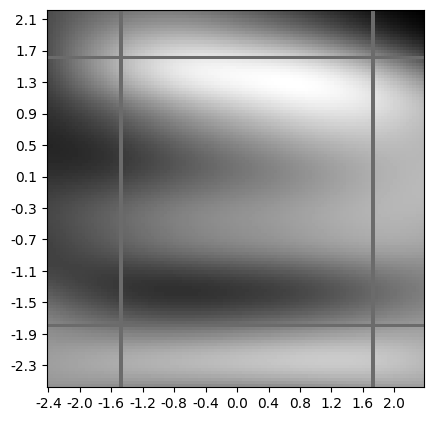

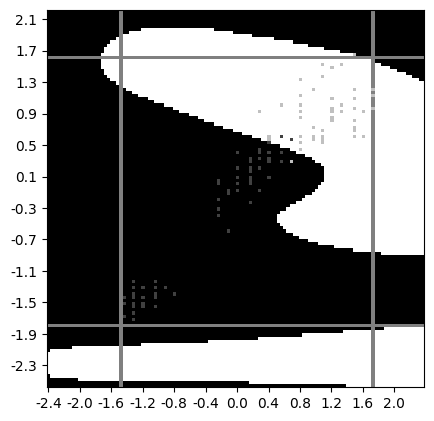

In [28]:
representation = irisVirginicaBestChromosome.representation
seed = representation[0]
octaves = representation[1]
threshold = representation[2]
scaleX = representation[3]
offsetX = representation[4]
scaleY = representation[5]
offsetY = representation[6]
zOffset = representation[-1]

imageScale = 4
imageOffset = 2

virginicaNoise = PerlinNoise(seed=seed, octaves=octaves)
imageWidth, imageHeight = 100, 100
border = 10

minX = floor((min(inputs, key=lambda input: input[0])[0] + imageOffset) * imageWidth / imageScale)
minY = floor((min(inputs, key=lambda input: input[1])[1] + imageOffset) * imageHeight / imageScale)
maxX = floor((max(inputs, key=lambda input: input[0])[0] + imageOffset) * imageWidth / imageScale)
maxY = floor((max(inputs, key=lambda input: input[1])[1] + imageOffset) * imageHeight / imageScale)

pic = []
for i in range(imageHeight + border, -border, -1):
    row = []
    for j in range(-border, imageWidth + border, 1):
        input = [(i / imageHeight - imageOffset / imageScale) * imageScale, (j / imageWidth - imageOffset / imageScale) * imageScale]
        processedInput = [] #copy.copy(input)
        for k in range(len(input)):
            scale = representation[2*k + 3]
            offset = representation[2*k + 4]
            value = input[k]
            processedInput.append(value * scale + offset)
        processedInput.append(zOffset)

        value = virginicaNoise(processedInput) + 0.5
        if i == minX-1 or i == maxX or j == minY-1 or j == maxY:
            value = 0.5
        row.append(value)
    pic.append(row)

#pic = [[noise([i/imageWidth * scaleX + offsetX, j/imageHeight * scaleY + offsetY]) for j in range(imageWidth, 0, -1)] for i in range(imageHeight)]

plt.figure(figsize=(5,5), dpi=100)
xticks = [x for x in range(0, imageWidth + border * 2, 10)]
plt.xticks(xticks, ["%.1f" % (((x - border) / imageWidth - imageOffset / imageScale) * imageScale) for x in xticks])
yticks = [y + border/imageScale for y in range(0, imageHeight + border * 2, 10)]
plt.yticks(yticks, reversed(["%.1f" % (((y - border) / imageHeight - imageOffset / imageScale) * imageScale) for y in yticks]))
plt.imshow(pic, cmap='gray')
plt.show()

#pic = [[noise([i/imageWidth * scaleX + offsetX, j/imageHeight * scaleY + offsetY]) > threshold for j in range(imageWidth, 0, -1)] for i in range(imageHeight)]
pic2 = []
for i in range(len(pic)):
    row = []
    for j in range(0, len(pic[i]), 1):
        value = pic[i][j] > threshold
        if pic[i][j] == 0.5:
            value = 0.5
        row.append(value)
    pic2.append(row)

for i in range(len(inputs)):
    input = inputs[i]
    processedInput = [] #copy.copy(input)
    for j in range(len(input)):
        scale = representation[2*j + 3]
        offset = representation[2*j + 4]
        value = input[j]
        processedInput.append(value * scale + offset)
    x = floor((imageScale - input[0] - imageOffset) * imageWidth / imageScale + border)
    y = floor((input[1] + imageOffset) * imageHeight / imageScale + border)
    color = 0.75 if results[i] == "Iris-virginica" else 0.25
    if x < len(pic2):
        if y < len(pic2[x]):
            pic2[x][y] = color

plt.figure(figsize=(5,5), dpi=100)
xticks = [x for x in range(0, imageWidth + border * 2, 10)]
plt.xticks(xticks, ["%.1f" % (((x - border) / imageWidth - imageOffset / imageScale) * imageScale) for x in xticks])
yticks = [y + border/imageScale for y in range(0, imageHeight + border * 2, 10)]
plt.yticks(yticks, reversed(["%.1f" % (((y - border) / imageHeight - imageOffset / imageScale) * imageScale) for y in yticks]))
plt.imshow(pic2, vmin=0, vmax=1, cmap='gray')
plt.show()

Putting together the individual one versus rest classifiers

The approach used to deal with overlap is to have a definite order in which the classifiers are used, any unlabelled inputs being assigned to the last class

Classifier validation accuracy:  0.9666666666666667
Classifier validation precisions:  {'Iris-setosa': 1.0, 'Iris-versicolor': 0.875, 'Iris-virginica': 1.0}
Classifier validation recalls:  {'Iris-setosa': 1.0, 'Iris-versicolor': 1.0, 'Iris-virginica': 0.9230769230769231}


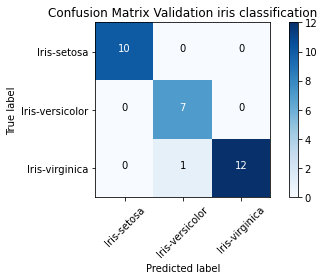

Classifier training accuracy:  0.975
Classifier training precisions:  {'Iris-setosa': 1.0, 'Iris-versicolor': 1.0, 'Iris-virginica': 0.925}
Classifier training recalls:  {'Iris-setosa': 1.0, 'Iris-versicolor': 0.9302325581395349, 'Iris-virginica': 1.0}


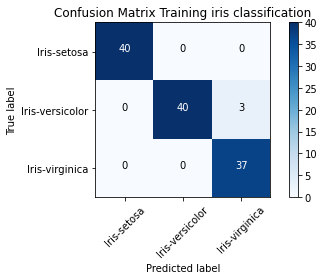

In [29]:
iris_classes = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
iris_chromosomes = [irisSetosaBestChromosome, irisVersicolorBestChromosome, irisVirginicaBestChromosome]
iris_classifiers = [PerlinNoise(seed=c.representation[0], octaves=c.representation[1]) for c in iris_chromosomes]

def classifyIris(input):
    for i in range(len(iris_classes)):
        iris_class = iris_classes[i]
        chromosome = iris_chromosomes[i]
        solution = chromosome.representation
        threshold = solution[2]
        zOffset = solution[-1]

        processedInput = [] #copy.copy(input)
        for j in range(len(input)):
            scale = solution[2*j + 3]
            offset = solution[2*j + 4]
            value = input[j]
            processedInput.append(value * scale + offset)
        processedInput.append(zOffset)

        iris_classifier = iris_classifiers[i]
        result = iris_classifier(processedInput) + 0.5 > threshold
        if result:
            return iris_class
            
    return iris_classes[-1]

def plotConfusionMatrix(cm, classNames, title):
    from sklearn.metrics import confusion_matrix
    import itertools 

    classes = classNames
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = 'Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                horizontalalignment = 'center',
                color = 'white' if cm[row, column] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

def evalMultiClass(computedLabels, realLabels, labelNames):
    from sklearn.metrics import confusion_matrix

    confMatrix = confusion_matrix(realLabels, computedLabels)
    acc = sum([confMatrix[i][i] for i in range(len(labelNames))]) / len(realLabels)
    precision = {}
    recall = {}
    for i in range(len(labelNames)):
        precision[labelNames[i]] = confMatrix[i][i] / sum([confMatrix[j][i] for j in range(len(labelNames))])
        recall[labelNames[i]] = confMatrix[i][i] / sum([confMatrix[i][j] for j in range(len(labelNames))])
    return acc, precision, recall, confMatrix


computedResults = [classifyIris(input) for input in validationInputs]
acc, prec, recall, cm = evalMultiClass(computedResults, validationResults, iris_classes)
print("Classifier validation accuracy: ", acc)
print("Classifier validation precisions: ", prec)
print("Classifier validation recalls: ", recall)
plotConfusionMatrix(cm, iris_classes, "Validation")

computedResults = [classifyIris(input) for input in trainInputs]
acc, prec, recall, cm = evalMultiClass(computedResults, trainResults, iris_classes)
print("Classifier training accuracy: ", acc)
print("Classifier training precisions: ", prec)
print("Classifier training recalls: ", recall)
plotConfusionMatrix(cm, iris_classes, "Training")